In [1]:
#library and data loading


pckg<-c("dplyr","readxl","haven","ggplot2","pdftools", "tidyverse",
        "ggplot2", "ggthemes", "ggrepel", "tm", "grid","PerformanceAnalytics",
        "e1071","doBy","fmsb","corrplot","VIM","DMwR","rpart",
        "rattle","rpart.plot","RColorBrewer","ipred",
        "randomForest","adabag","lme4","caret","class","ROCR","Imap","caret","randomForest","naniar","gridExtra","GGally","leaflet","parsedate")
#sapply(pckg,install.packages,character.only=TRUE) #library loading
sapply(pckg, function(x) require(x,quietly=TRUE,character.only=TRUE,warn.conflicts = FALSE )) #library loading

memory.limit();
memory.limit(100000000000);

kc_house_base<-read.csv("kc_house_data.csv", na.strings = "NA",stringsAsFactors = FALSE) #data loading
kc_house<-read.csv("kc_house_data.csv", na.strings = "NA",stringsAsFactors = FALSE) #data loading


Warning message:
"package 'dplyr' was built under R version 3.5.3"Warning message:
"package 'pdftools' was built under R version 3.5.3"Warning message:
"package 'tidyverse' was built under R version 3.5.3"-- Attaching packages --------------------------------------- tidyverse 1.2.1 --
√ tibble  2.1.1     √ purrr   0.2.5
√ tidyr   0.8.3     √ stringr 1.3.1
√ readr   1.1.1     √ forcats 0.3.0
Warning message:
"package 'tibble' was built under R version 3.5.3"Warning message:
"package 'tidyr' was built under R version 3.5.3"-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
Warning message:
"package 'ggthemes' was built under R version 3.5.3"Warning message:
"package 'ggrepel' was built under R version 3.5.3"Warning message:
"package 'tm' was built under R version 3.5.3"Warning message:
"package 'NLP' was built under R version 3.5.2"
Attaching package: 'NLP'

The following object is 

dplyr               readxl                haven 
                TRUE                 TRUE                 TRUE 
             ggplot2             pdftools            tidyverse 
                TRUE                 TRUE                 TRUE 
             ggplot2             ggthemes              ggrepel 
                TRUE                 TRUE                 TRUE 
                  tm                 grid PerformanceAnalytics 
                TRUE                 TRUE                 TRUE 
               e1071                 doBy                 fmsb 
                TRUE                 TRUE                 TRUE 
            corrplot                  VIM                 DMwR 
                TRUE                 TRUE                 TRUE 
               rpart               rattle           rpart.plot 
                TRUE                 TRUE                 TRUE 
        RColorBrewer                ipred         randomForest 
                TRUE                 TRUE                 TRUE 
              adabag                 lme4                caret 
                TRUE                 TRUE                 TRUE 
               class                 ROCR                 Imap 
                TRUE                 TRUE                 TRUE 
               caret         randomForest               naniar 
                TRUE                 TRUE                 TRUE 
           gridExtra               GGally              leaflet 
                TRUE                 TRUE                 TRUE 
           parsedate 
                TRUE

[1] 8076

[1] 1e+11

In [2]:

#missing data

apply(kc_house,MARGIN=2,FUN=any_na)
kc_house[!complete.cases(kc_house),]

#outlier 

for (i in (3:ncol(kc_house))) {
    
    lower<-kc_house[which(kc_house[,i]<quantile(kc_house[,i],c(0.02))),]
    assign(paste(colnames(kc_house)[i],"_out_low",sep=""),lower)
    
    up<-kc_house[which(kc_house[,i]>quantile(kc_house[,i],c(0.99))),]
    assign(paste(colnames(kc_house)[i],"_out_up",sep=""),up)
}


id          date         price      bedrooms     bathrooms 
        FALSE         FALSE         FALSE         FALSE         FALSE 
  sqft_living      sqft_lot        floors    waterfront          view 
        FALSE         FALSE         FALSE         FALSE         FALSE 
    condition         grade    sqft_above sqft_basement      yr_built 
        FALSE         FALSE         FALSE         FALSE         FALSE 
 yr_renovated       zipcode           lat          long sqft_living15 
        FALSE         FALSE         FALSE         FALSE         FALSE 
   sqft_lot15 
        FALSE

Warning message in cbind(parts$left, ellip_h, parts$right, deparse.level = 0L):
"number of rows of result is not a multiple of vector length (arg 2)"Warning message in cbind(parts$left, ellip_h, parts$right, deparse.level = 0L):
"number of rows of result is not a multiple of vector length (arg 2)"Warning message in cbind(parts$left, ellip_h, parts$right, deparse.level = 0L):
"number of rows of result is not a multiple of vector length (arg 2)"Warning message in cbind(parts$left, ellip_h, parts$right, deparse.level = 0L):
"number of rows of result is not a multiple of vector length (arg 2)"

id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15


In [3]:


#test/training split

smp_size <- floor(0.75 * nrow(kc_house)) # 75% of the sample size

## set the seed to make your partition reproducible
set.seed(123)
train_ind <- sample(seq_len(nrow(kc_house)), size = smp_size)

kc_house_base<- kc_house_base[train_ind, ]
kc_house<- kc_house[train_ind, ]
kc_house_test <- kc_house[-train_ind, ]

In [4]:

##overal EDA



date_var<-c("date","yr_built","yr_renovated")
fac_var<-c("waterfront","zipcode","grade","condition")
num_var<-c("price","bedrooms","bathrooms","sqft_living","sqft_lot","floors","view","sqft_above","sqft_basement","lat","long","sqft_living15","sqft_lot15")


unique_zipcode<-unique(kc_house$zipcode)
unique_waterfront<-unique(kc_house$waterfront)
unique_grade<-unique(kc_house$grade)
unique_condition<-unique(kc_house$condition)


kc_house$zipcode<-factor(kc_house$zipcode,levels=unique_zipcode)
kc_house$waterfront<-factor(kc_house$waterfront,levels=unique_waterfront)
kc_house$grade<-factor(kc_house$grade,levels=unique_grade)
kc_house$condition<-factor(kc_house$condition,levels=unique_condition)

str(kc_house)



kc_house$date<-substr(kc_house$date,1,8)
kc_house$date_YMD<-as.Date(kc_house$date,format="%Y%m%d")

'data.frame':	16209 obs. of  21 variables:
 $ id           : num  6.19e+09 1.12e+09 2.52e+09 7.55e+09 5.56e+09 ...
 $ date         : chr  "20140514T000000" "20150327T000000" "20141205T000000" "20140714T000000" ...
 $ price        : num  364000 875000 1406890 550000 1240000 ...
 $ bedrooms     : int  4 5 5 3 5 2 3 4 4 3 ...
 $ bathrooms    : num  1.75 3.25 2.25 1.75 4 1 2.5 2.5 2 1.75 ...
 $ sqft_living  : int  2010 4230 3580 1410 4410 880 2070 3440 2340 1340 ...
 $ sqft_lot     : int  8625 21455 16789 5000 14380 7683 12708 6332 6000 6250 ...
 $ floors       : num  1 2 2 1 2 1 2 2 1 1 ...
 $ waterfront   : Factor w/ 2 levels "0","1": 1 1 1 1 1 1 1 1 1 1 ...
 $ view         : int  0 0 0 0 0 0 0 0 0 0 ...
 $ condition    : Factor w/ 5 levels "4","3","5","1",..: 1 2 3 1 2 2 2 2 3 1 ...
 $ grade        : Factor w/ 12 levels "7","10","9","11",..: 1 2 3 1 4 5 6 2 6 1 ...
 $ sqft_above   : int  1340 2720 3580 810 4410 880 2070 3440 1270 1090 ...
 $ sqft_basement: int  670 1510 0 600 0 0 0 0 10

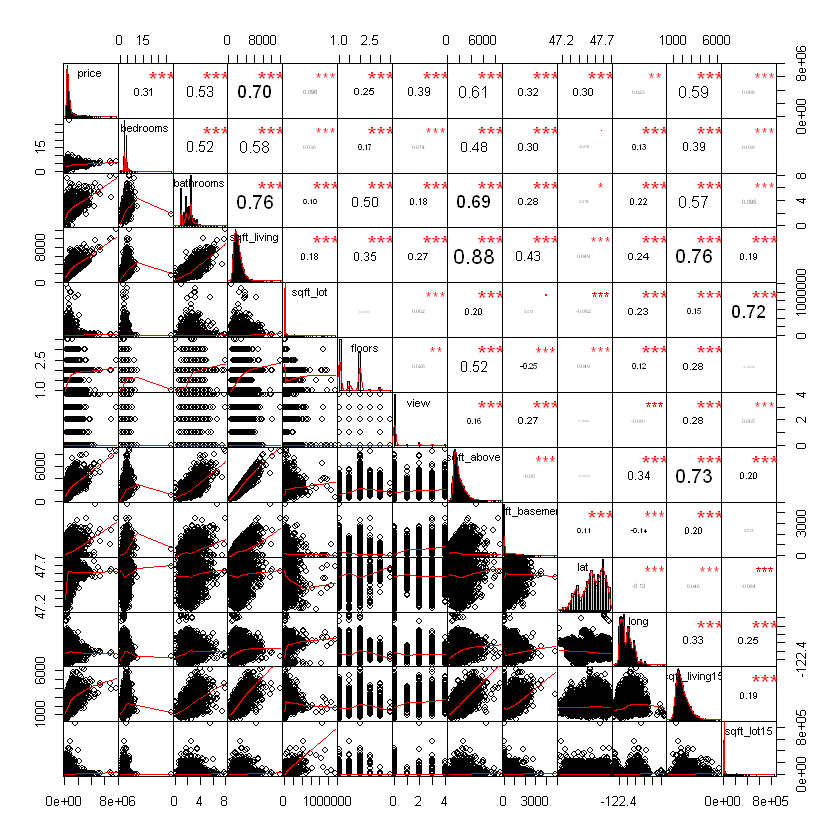

In [5]:
#numerical value
chart.Correlation(kc_house[,num_var], pch = 19, method = "pearson")

In [6]:
#distribution
distribution <- as.data.frame(t(sapply(kc_house[,num_var], quantile)))
distribution$Mean <- sapply(kc_house[,num_var], mean)
distribution$SD <- sapply(kc_house[,num_var], sd)
distribution$skenewss <- sapply(kc_house[,num_var], skewness)
distribution$kurtosis <- sapply(kc_house[,num_var], kurtosis)
distribution<-round(distribution, 2)
distribution

,0%,25%,50%,75%,100%,Mean,SD,skenewss,kurtosis
price,75000.00,322500.00,450000.00,640000.00,7700000.00,539118.63,371022.18,4.28,38.99
bedrooms,0.00,3.00,3.00,4.00,33.00,3.37,0.94,2.41,62.79
bathrooms,0.00,1.50,2.25,2.50,8.00,2.11,0.77,0.56,1.43
sqft_living,290.00,1420.00,1910.00,2538.00,12050.00,2075.63,919.65,1.46,4.70
sqft_lot,520.00,5100.00,7650.00,10769.00,1164794.00,15306.38,40714.07,11.31,197.67
floors,1.00,1.00,1.50,2.00,3.50,1.49,0.54,0.63,-0.46
view,0.00,0.00,0.00,0.00,4.00,0.24,0.77,3.39,10.80
sqft_above,290.00,1190.00,1550.00,2200.00,8860.00,1784.76,829.36,1.46,3.40
sqft_basement,0.00,0.00,0.00,560.00,4820.00,290.87,441.40,1.59,2.85
lat,47.16,47.47,47.57,47.68,47.78,47.56,0.14,-0.48,-0.69


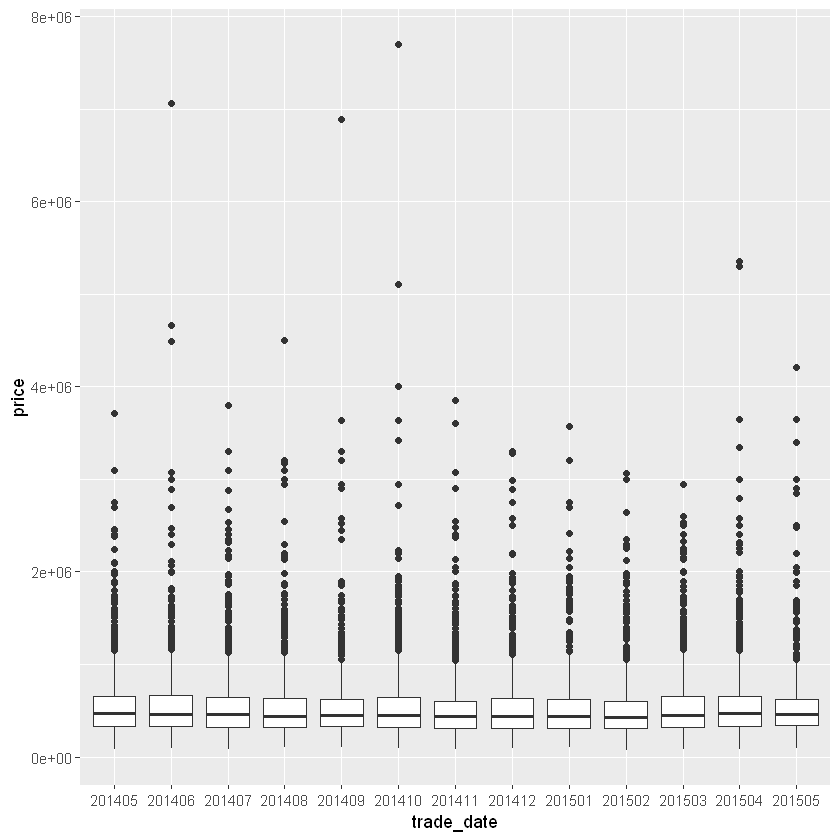

In [7]:

###feature engineering

##date, year built, renovated year (date)



#date

kc_house$trade_date<-substr(kc_house$date,1,6)
ggplot(data=kc_house,aes(x=trade_date, y=price))+geom_boxplot() 


In [8]:

# supply and demand

kc_house%>%group_by(trade_date)%>%summarize(count=n())

trade_date,count
201405,1328
201406,1603
201407,1620
201408,1472
201409,1319
201410,1409
201411,1065
201412,1115
201501,751
201502,958


In [9]:

# the age of houses
kc_house$age_sold<-as.numeric(substr(kc_house$date,1,4))-kc_house$yr_built
kc_house$age_sold_group<-ifelse(kc_house$age_sold<10,"0~9",
                                ifelse(kc_house$age_sold<20,"10~19",
                                       ifelse(kc_house$age_sold<30,"20~29",
                                              ifelse(kc_house$age_sold<40,"30~39",
                                                     ifelse(kc_house$age_sold<50,"40~49",
                                                            ifelse(kc_house$age_sold<60,"50~59",
                                                                   ifelse(kc_house$age_sold<70,"60~69",
                                                                          ifelse(kc_house$age_sold<80,"70~79",
                                                                                 ifelse(kc_house$age_sold<90,"80~89",
                                                                                        ifelse(kc_house$age_sold<100,"90~99","100+"))))))))))



#binary of renovation
kc_house$yr_renovated_bi<-ifelse(kc_house$yr_renovated==0,"0","1") 
kc_house$yr_renovated_bi<-factor(kc_house$yr_renovated_bi,levels=c("0","1")) #factor

# the year
kc_house$age_sold_reno<-ifelse(kc_house$yr_renovated==0,kc_house$age_sold,as.numeric(substr(kc_house$date,1,4))-kc_house$yr_renovated)
kc_house$yr_built_reno<-ifelse(kc_house$yr_renovated==0,kc_house$yr_built,kc_house$yr_renovated)


`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'
`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'


TableGrob (3 x 1) "arrange": 3 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (2-2,1-1) arrange gtable[layout]
3 3 (3-3,1-1) arrange gtable[layout]

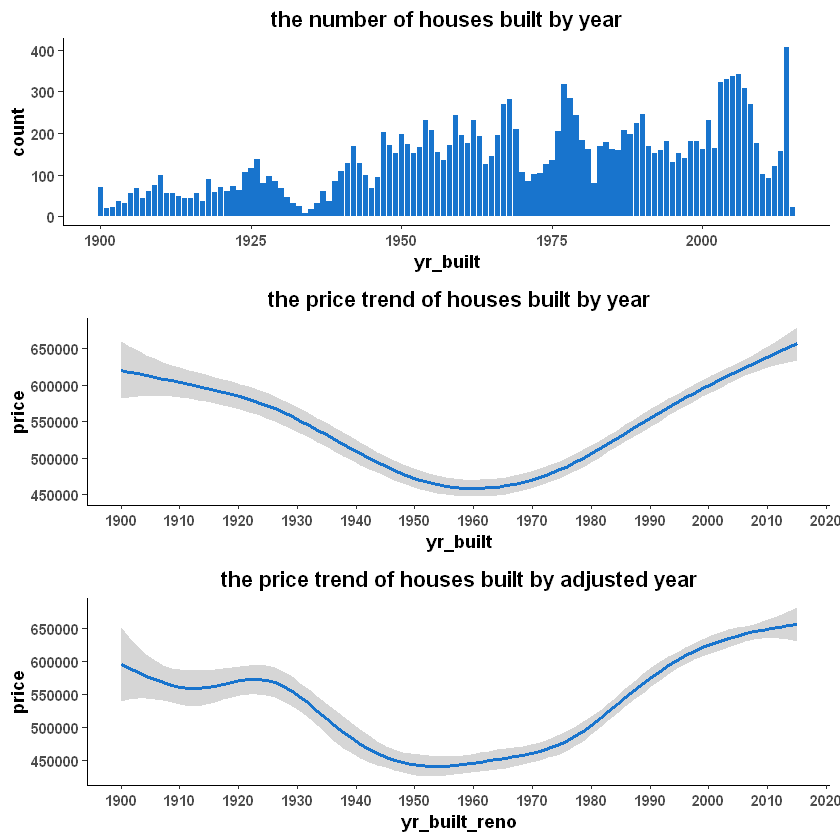

In [10]:


v1 <- ggplot(kc_house, aes(yr_built)) +
    geom_bar(fill = "dodgerblue3") +
    ggtitle("the number of houses built by year") +
    theme_classic() +
    theme(text = element_text(face ="bold"),
          plot.title = element_text(hjust = 0.5))


v2 <- ggplot(kc_house, aes(yr_built, price)) +
    geom_smooth(se = TRUE, colour = "dodgerblue3") +
    scale_x_continuous(breaks = scales::pretty_breaks(n = 10)) +
    scale_y_continuous(breaks = scales::pretty_breaks(n = 8)) +
    ggtitle("the price trend of houses built by year") +
    theme_classic() +
    theme(text = element_text(face = "bold"),
          plot.title=element_text(hjust=0.5))

v3 <- ggplot(kc_house, aes(yr_built_reno, price)) +
    geom_smooth(se = TRUE, colour = "dodgerblue3") +
    scale_x_continuous(breaks = scales::pretty_breaks(n = 10)) +
    scale_y_continuous(breaks = scales::pretty_breaks(n = 8)) +
    ggtitle("the price trend of houses built by adjusted year") +
    theme_classic() +
    theme(text = element_text(face = "bold"),
          plot.title=element_text(hjust=0.5))


v4<-ggplot(kc_house)+
    geom_smooth(aes(yr_built_reno, price),se=FALSE, colour = "firebrick2")+
    geom_smooth(aes(yr_built, price),se=FALSE, colour="dodgerblue3")+
    xlab("(built/adjusted built) year ")+
    ggtitle("comparison of price by adjusted year") +
    theme_classic()+
    theme(text = element_text(face = "bold"),
          plot.title=element_text(hjust=0.5))

price_yr<- grid.arrange(v1,v2,v3)
price_yr


`geom_smooth()` using method = 'loess' and formula 'y ~ x'
`geom_smooth()` using method = 'loess' and formula 'y ~ x'


TableGrob (2 x 2) "arrange": 4 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]
3 3 (2-2,1-1) arrange gtable[layout]
4 4 (2-2,2-2) arrange gtable[layout]

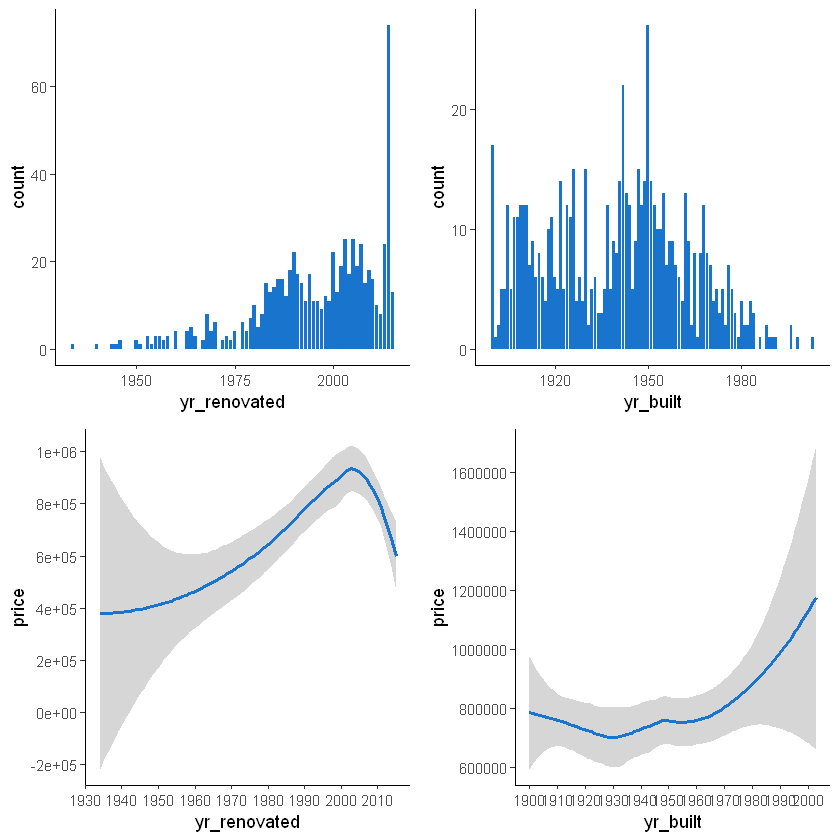

In [11]:

reno_1 <- ggplot(kc_house%>%filter(yr_renovated_bi=="1"), aes(yr_renovated)) +
    geom_bar(fill = "dodgerblue3") +
    theme_classic() 


reno_1_1 <- ggplot(kc_house%>%filter(yr_renovated_bi=="1"), aes(yr_built)) +
    geom_bar(fill = "dodgerblue3") +
    theme_classic() 


reno_2 <- ggplot(kc_house%>%filter(yr_renovated_bi=="1"), aes(yr_renovated, price)) +
    geom_smooth(se = TRUE, colour = "dodgerblue3") +
    scale_x_continuous(breaks = scales::pretty_breaks(n = 10)) +
    scale_y_continuous(breaks = scales::pretty_breaks(n = 8)) +
    theme_classic() 


reno_2_2 <- ggplot(kc_house%>%filter(yr_renovated_bi=="1"), aes(yr_built, price)) +
    geom_smooth(se = TRUE, colour = "dodgerblue3") +
    scale_x_continuous(breaks = scales::pretty_breaks(n = 10)) +
    scale_y_continuous(breaks = scales::pretty_breaks(n = 8)) +
    theme_classic()


price_reno_yr<- grid.arrange(reno_1, reno_1_1, reno_2,reno_2_2)
price_reno_yr

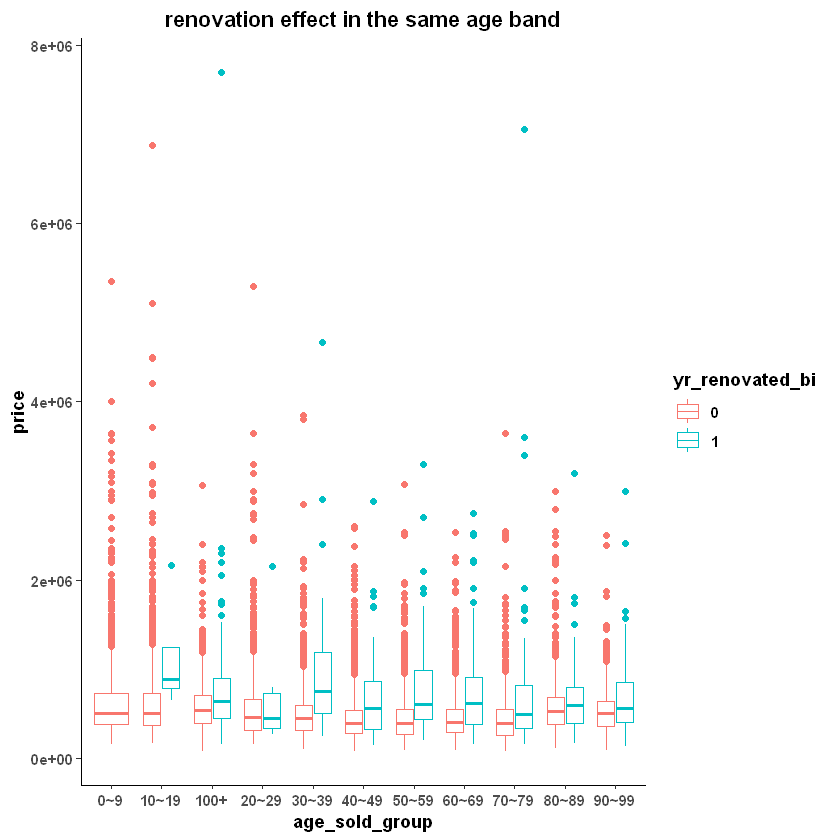

In [12]:

reno3 <- ggplot(kc_house,aes(age_sold_group,price,color=yr_renovated_bi))+
    geom_boxplot()+
    ggtitle("renovation effect in the same age band") +
    theme_classic() +
    theme(text = element_text(face ="bold"),
          plot.title = element_text(hjust = 0.5))

reno3

TableGrob (2 x 1) "arrange": 2 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (2-2,1-1) arrange gtable[layout]

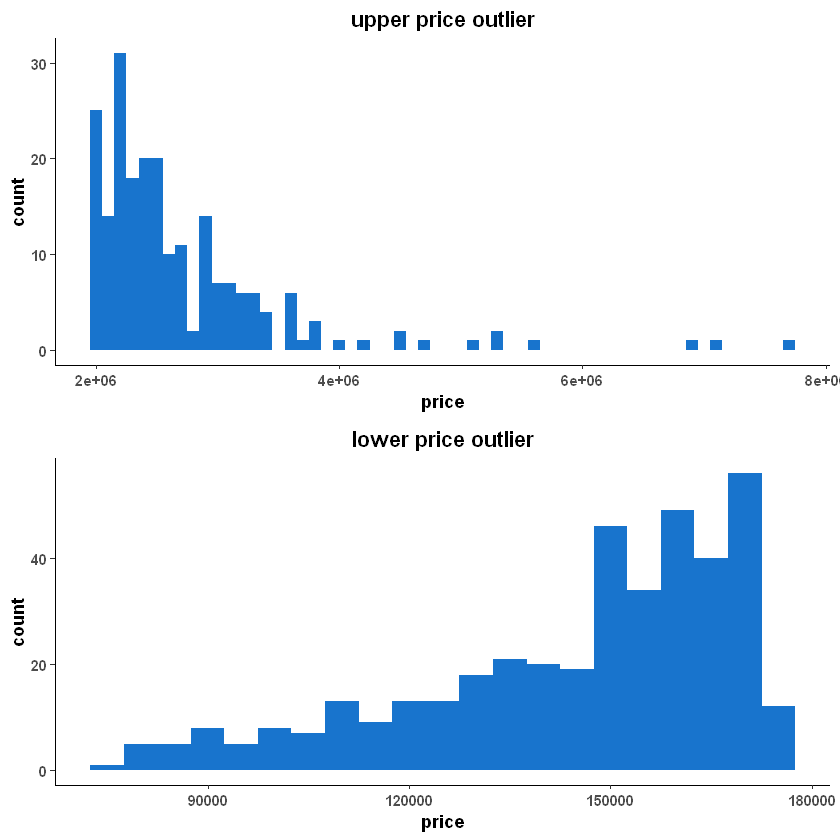

In [13]:
## price 


price_1 <- ggplot(price_out_up, aes(price)) +
    geom_histogram(fill = "dodgerblue3",binwidth = 100000) +
    ggtitle("upper price outlier") +
    theme_classic() +
    theme(text = element_text(face ="bold"),
          plot.title = element_text(hjust = 0.5))

price_2  <- ggplot(price_out_low, aes(price)) +
    geom_histogram(fill = "dodgerblue3",binwidth = 5000) +
    ggtitle("lower price outlier") +
    theme_classic() +
    theme(text = element_text(face ="bold"),
          plot.title = element_text(hjust = 0.5))

price_outlier<- grid.arrange(price_1,price_2)
price_outlier


In [14]:

##price category split by quantile

kc_house$price_rank<-rank(-kc_house$price,na.last="keep")
kc_house<-kc_house%>%arrange(desc(kc_house$price)) #price rank

summary(kc_house$price)

quantile(kc_house$price)[1] #qunatile
quantile(kc_house$price)[2]
quantile(kc_house$price)[3]
quantile(kc_house$price)[4]
quantile(kc_house$price)[5]


kc_house[which(kc_house$price>=quantile(kc_house$price)[4]),c("price_q")]<-c("1") #price qunatile 
kc_house[which(kc_house$price<quantile(kc_house$price)[4] & kc_house$price>=quantile(kc_house$price)[3]),c("price_q")]<-c("2")
kc_house[which(kc_house$price<quantile(kc_house$price)[3] & kc_house$price>=quantile(kc_house$price)[2]),c("price_q")]<-c("3")
kc_house[which(kc_house$price<quantile(kc_house$price)[2]),c("price_q")]<-c("4")


summary(kc_house$lat)
summary(kc_house$long)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  75000  322500  450000  539119  640000 7700000 

0% 
75000

25% 
322500

50% 
450000

75% 
640000

100% 
7700000

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  47.16   47.47   47.57   47.56   47.68   47.78 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 -122.5  -122.3  -122.2  -122.2  -122.1  -121.3 

In [15]:

#location segmentation

kc_house$lat_point<-NA
kc_house$lat_point<-ifelse(kc_house$lat<47.2,1,
                           ifelse(kc_house$lat<47.3,2,
                                  ifelse(kc_house$lat<47.4,3,
                                         ifelse(kc_house$lat<47.5,4,
                                                ifelse(kc_house$lat<47.6,5,
                                                       ifelse(kc_house$lat<47.7,7,
                                                              ifelse(kc_house$lat<47.8,8,0)))))))


kc_house$long_point<-ifelse(kc_house$long<(-122.5),1,
                            ifelse(kc_house$long<(-122.25),2,
                                   ifelse(kc_house$long<(-122.00),3,
                                          ifelse(kc_house$long<(-121.75),4,
                                                 ifelse(kc_house$long<(-121.50),5,
                                                        ifelse(kc_house$long<(-121.25),7,
                                                               ifelse(kc_house$long<(-121.00),8,0)))))))


kc_house$location<-paste(kc_house$lat_point,kc_house$long_point,sep="")


kc_house_q1<-kc_house[which(kc_house$price_q=="1"),]
kc_house_q2<-kc_house[which(kc_house$price_q=="2"),]
kc_house_q3<-kc_house[which(kc_house$price_q=="3"),]
kc_house_q4<-kc_house[which(kc_house$price_q=="4"),]

TableGrob (3 x 2) "arrange": 6 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]
3 3 (2-2,1-1) arrange gtable[layout]
4 4 (2-2,2-2) arrange gtable[layout]
5 5 (3-3,1-1) arrange gtable[layout]
6 6 (3-3,2-2) arrange gtable[layout]

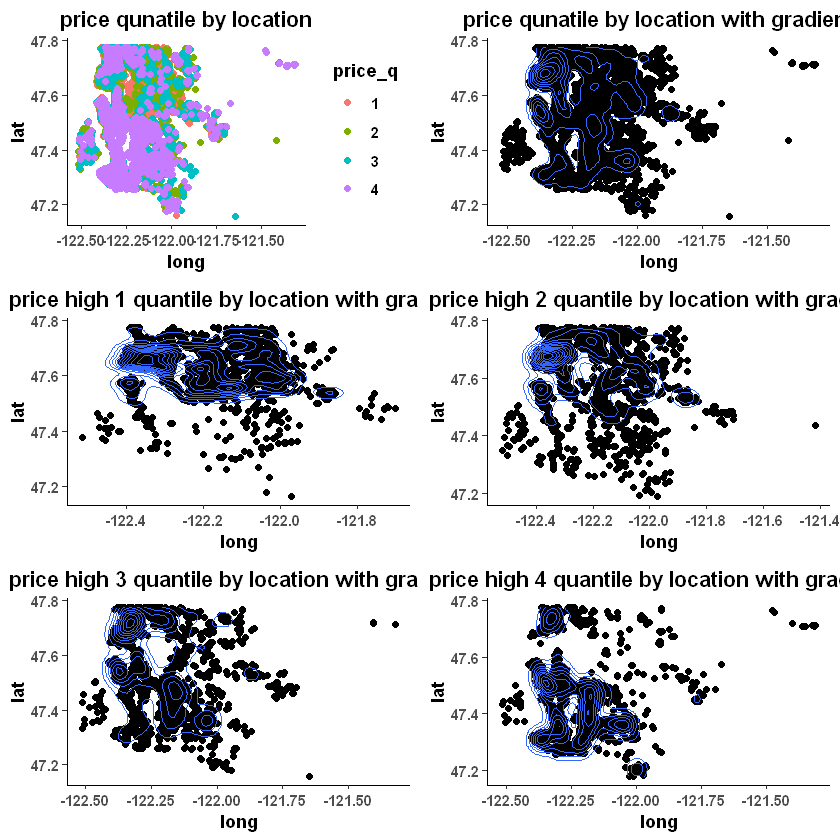

In [17]:

#location visualization 2
loc_1<-ggplot(data=kc_house,mapping=aes(x=long,y=lat,color=price_q))+
    geom_point()+
    ggtitle("price qunatile by location")+
    theme_classic()+
    theme(text = element_text(face ="bold"),
          plot.title = element_text(hjust = 0.5))

loc_2<-ggplot(data=kc_house,mapping=aes(x=long,y=lat))+
    geom_point()+
    stat_density2d()+
    ggtitle("price qunatile by location with gradient")+
    theme_classic()+
    theme(text = element_text(face ="bold"),
          plot.title = element_text(hjust = 0.5))

loc_q1<-ggplot(data=kc_house[which(kc_house$price_q=="1"),],mapping=aes(x=long,y=lat))+
    geom_point()+
    stat_density2d()+
    ggtitle("price high 1 quantile by location with gradient")+
    theme_classic()+
    theme(text = element_text(face ="bold"),
          plot.title = element_text(hjust = 0.5))

loc_q2<-ggplot(data=kc_house[which(kc_house$price_q=="2"),],mapping=aes(x=long,y=lat))+
    geom_point()+
    stat_density2d()+
    ggtitle("price high 2 quantile by location with gradient")+
    theme_classic()+
    theme(text = element_text(face ="bold"),
          plot.title = element_text(hjust = 0.5))

loc_q3<-ggplot(data=kc_house[which(kc_house$price_q=="3"),],mapping=aes(x=long,y=lat))+
    geom_point()+
    stat_density2d()+
    ggtitle("price high 3 quantile by location with gradient")+
    theme_classic()+
    theme(text = element_text(face ="bold"),
          plot.title = element_text(hjust = 0.5))

loc_q4<-ggplot(data=kc_house[which(kc_house$price_q=="4"),],mapping=aes(x=long,y=lat))+
    geom_point()+
    stat_density2d()+
    ggtitle("price high 4 quantile by location with gradient")+
    theme_classic()+
    theme(text = element_text(face ="bold"),
          plot.title = element_text(hjust = 0.5))


loc_total<- grid.arrange(loc_1,loc_2,loc_q1,loc_q2,loc_q3,loc_q4)
loc_total

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'


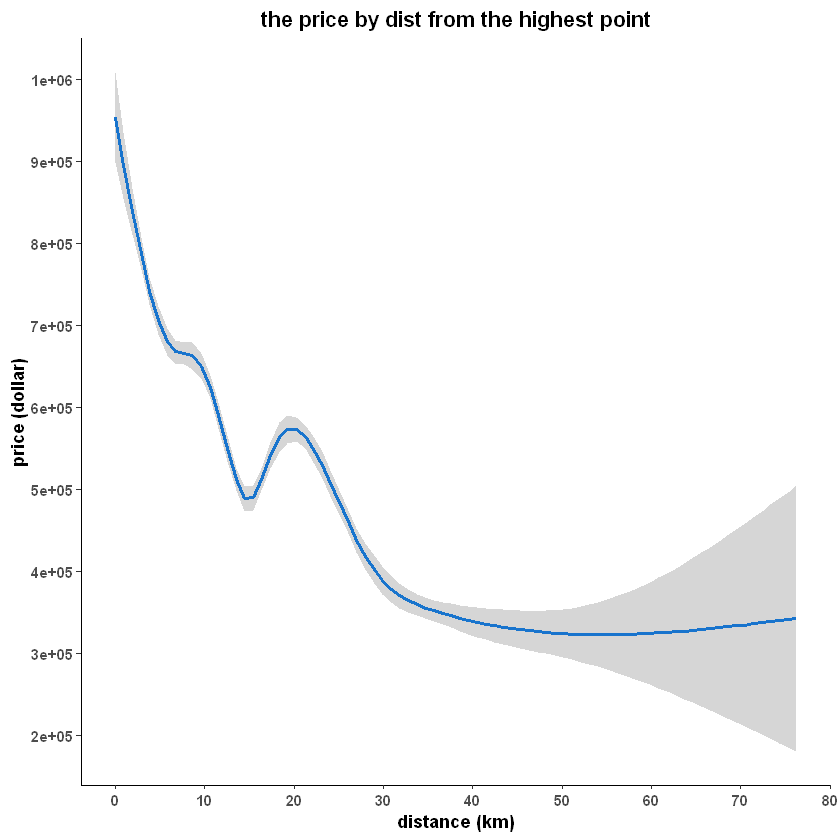

In [18]:

##Distance calculation from the highest point

kc_house$dist<-NA
for (i in 1:nrow(kc_house)) {
    
    kc_house[i,c("dist")] <- gdist(lon.1 = kc_house$long[i], 
                                   lat.1 = kc_house$lat[i], 
                                   lon.2 = kc_house$long[1], 
                                   lat.2 = kc_house$lat[1], 
                                   units="km")
}


v5<-ggplot(kc_house,aes(dist,price))+
    xlab("distance (km)")+
    ylab("price (dollar)")+
    geom_smooth(se=TRUE, colour="dodgerblue3")+
    scale_x_continuous(breaks = scales::pretty_breaks(n = 10)) +
    scale_y_continuous(breaks = scales::pretty_breaks(n = 8)) +
    ggtitle("the price by dist from the highest point") +
    theme_classic()+
    theme(text=element_text(face="bold"),
          plot.title=element_text(hjust=0.5))

v5

In [19]:


#lot category split
kc_house$lot_rank<-rank(-kc_house$sqft_lot,na.last="keep")
kc_house<-kc_house%>%arrange(desc(kc_house$sqft_lot)) #lot rank

quantile(kc_house$sqft_lot)[2]
quantile(kc_house$sqft_lot)[3]
quantile(kc_house$sqft_lot)[4]
quantile(kc_house$sqft_lot)[5]

qunatile_lot<-quantile(kc_house$sqft_lot, probs = seq(0, 1, 0.05), na.rm = FALSE, names = TRUE, type = 7)
qunatile_lot

kc_house[which(kc_house$sqft_lot>=qunatile_lot[20]),c("sqft_lot_q")]<-c("1") #95%
kc_house[which(kc_house$sqft_lot<qunatile_lot[20] & kc_house$sqft_lot>=qunatile_lot[19]),c("sqft_lot_q")]<-c("2") #90%
kc_house[which(kc_house$sqft_lot<qunatile_lot[19] & kc_house$sqft_lot>=qunatile_lot[18]),c("sqft_lot_q")]<-c("3") #85%
kc_house[which(kc_house$sqft_lot<qunatile_lot[18] & kc_house$sqft_lot>=qunatile_lot[17]),c("sqft_lot_q")]<-c("4") #80%
kc_house[which(kc_house$sqft_lot<qunatile_lot[17] & kc_house$sqft_lot>=qunatile_lot[16]),c("sqft_lot_q")]<-c("5") #75%
kc_house[which(kc_house$sqft_lot<qunatile_lot[16] & kc_house$sqft_lot>=qunatile_lot[11]),c("sqft_lot_q")]<-c("6") #50~75%
kc_house[which(kc_house$sqft_lot<qunatile_lot[11] & kc_house$sqft_lot>=qunatile_lot[6]),c("sqft_lot_q")]<-c("7")  #25~50%
kc_house[which(kc_house$sqft_lot<qunatile_lot[6]),c("sqft_lot_q")]<-c("8") #0~50%


summary(kc_house[which(kc_house$sqft_lot_q=="1"),][7])

25% 
5100

50% 
7650

75% 
10769

100% 
1164794

0%        5%       10%       15%       20%       25%       30%       35% 
    520.0    1765.8    3329.6    4041.0    4708.0    5100.0    5700.0    6190.2 
      40%       45%       50%       55%       60%       65%       70%       75% 
   6815.6    7250.0    7650.0    8100.0    8556.0    9210.2    9847.0   10769.0 
      80%       85%       90%       95%      100% 
  12350.0   15188.0   21780.0   43560.0 1164794.0

    sqft_lot      
 Min.   :  43560  
 1st Qu.:  54014  
 Median :  88426  
 Mean   : 135810  
 3rd Qu.: 201247  
 Max.   :1164794  

Warning message:
"Removed 807 rows containing non-finite values (stat_bin)."Warning message:
"Removed 1 rows containing missing values (geom_bar)."Warning message:
"Removed 15389 rows containing non-finite values (stat_bin)."Warning message:
"Removed 1 rows containing missing values (geom_bar)."

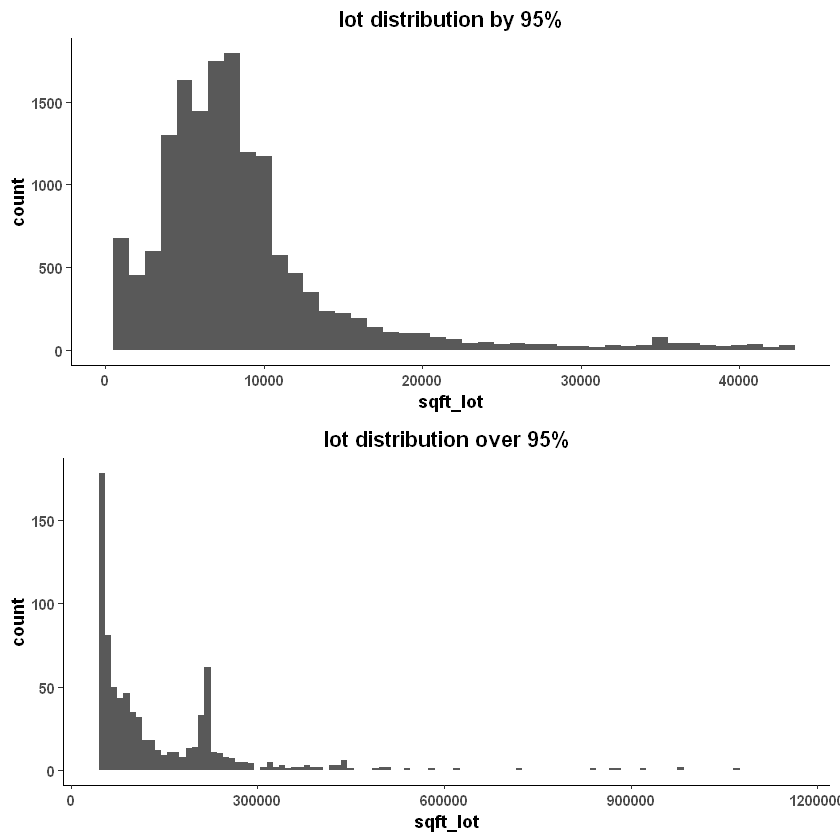

In [20]:

lot_1<-ggplot(kc_house,aes(sqft_lot))+
    geom_histogram(binwidth=1000)+
    ggtitle("lot distribution by 95%")+
    xlim(c(0,qunatile_lot[20]))+
    theme_classic()+
    theme(text=element_text(face="bold"),
          plot.title=element_text(hjust=0.5))

lot_2<-ggplot(kc_house,aes(sqft_lot))+
    geom_histogram(binwidth=10000)+
    ggtitle("lot distribution over 95%")+
    xlim(c(qunatile_lot[20],qunatile_lot[21]))+
    theme_classic()+
    theme(text=element_text(face="bold"),
          plot.title=element_text(hjust=0.5))


lot_total<- grid.arrange(lot_1,lot_2)

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'


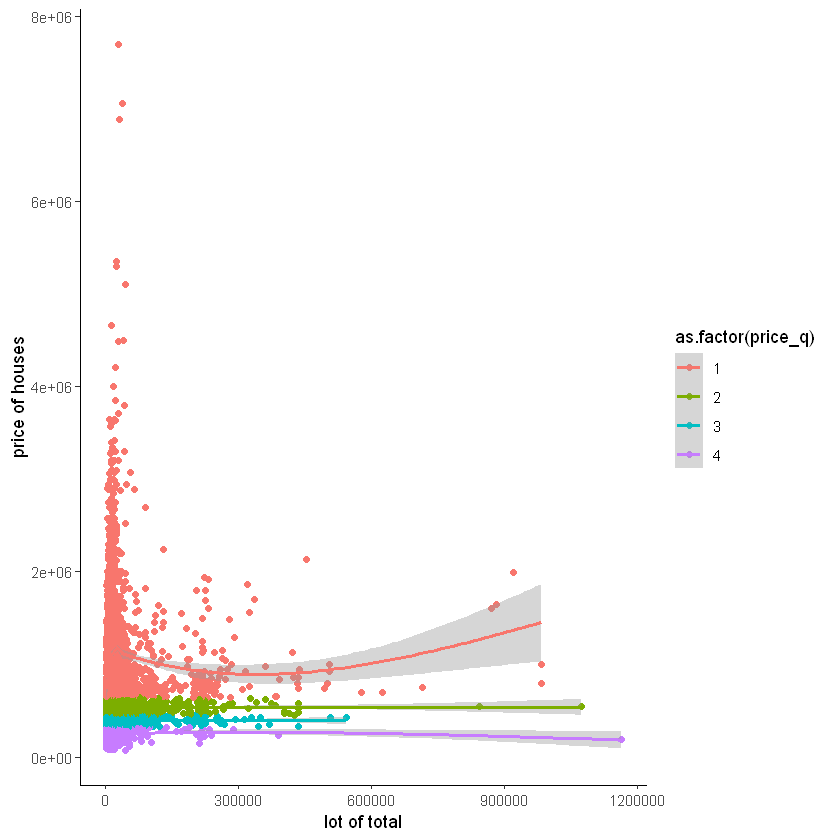

In [21]:
#district 

district<-as.matrix(kc_house%>%group_by(location)%>%summarize(count=n())%>%arrange(-count)%>%filter(count>500)%>%select(location))



district_total<-ggplot(kc_house, aes(sqft_lot, price, col=as.factor(price_q)))+
    geom_jitter()+
    xlab("lot of total")+  
    ylab("price of houses")+
    theme_classic()+
    geom_smooth(se=TRUE)

district_total

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'
`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'
`geom_smooth()` using method = 'loess' and formula 'y ~ x'


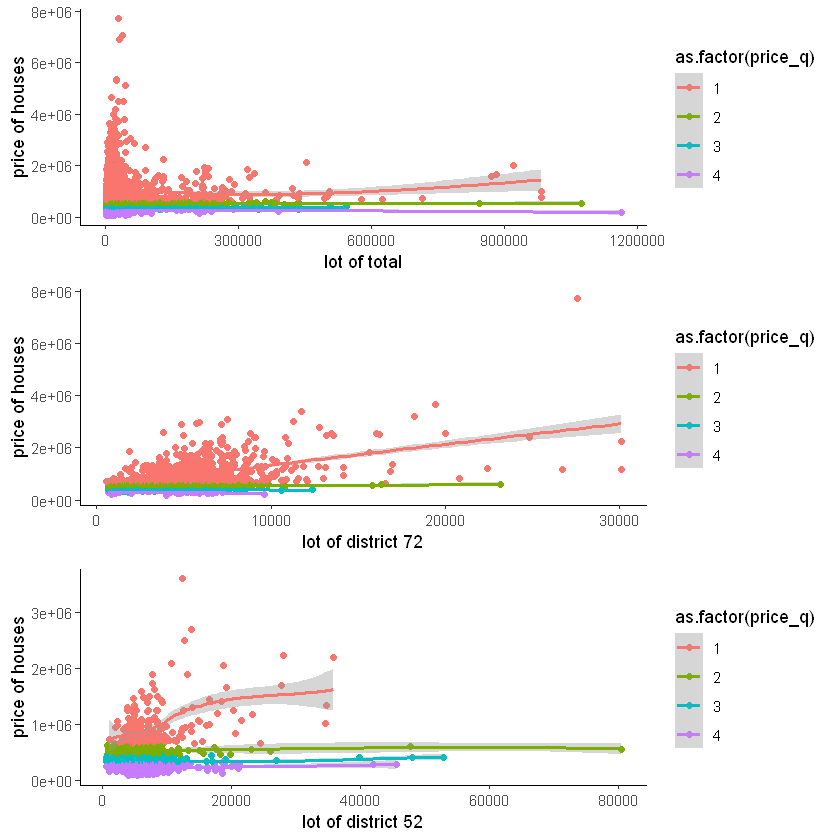

In [23]:
for (i in (1:11)) {
    
    a<-ggplot(kc_house%>%filter(location==district[i]), aes(sqft_lot, price, col=as.factor(price_q)))+
        geom_jitter()+
        xlab(paste("lot of district ",district[i],sep=""))+  
        ylab("price of houses")+
        theme_classic()+
        geom_smooth(se=TRUE)
    
    
    
    assign(paste("district_",i,sep=""),a)
}

grid.arrange(district_total,district_1,district_2)

`geom_smooth()` using method = 'loess' and formula 'y ~ x'
`geom_smooth()` using method = 'loess' and formula 'y ~ x'
`geom_smooth()` using method = 'loess' and formula 'y ~ x'


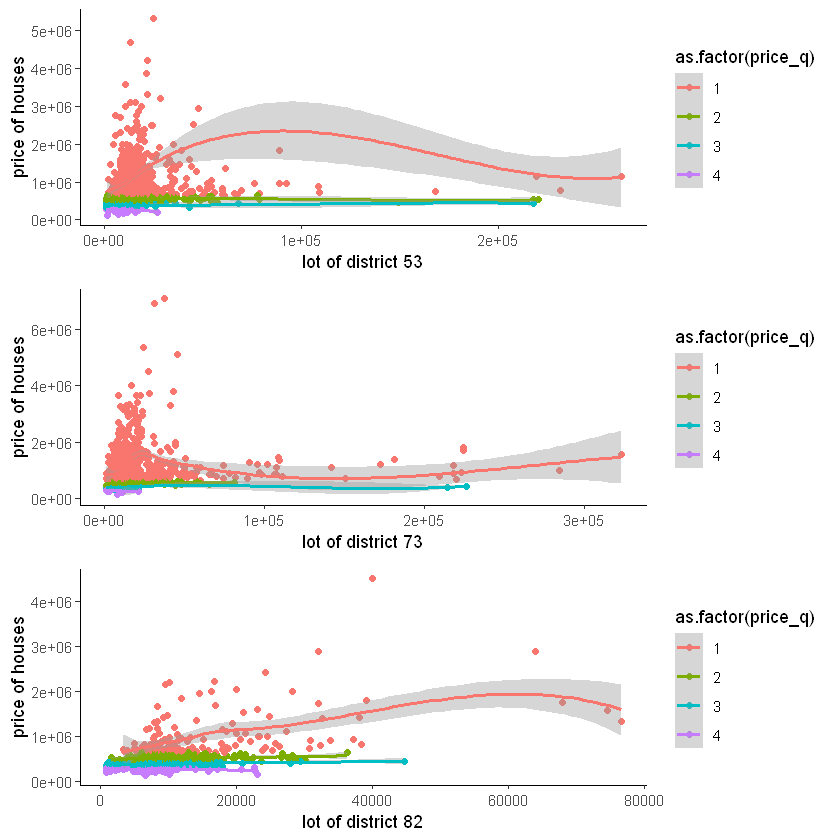

In [24]:
grid.arrange(district_3,district_4,district_5)

`geom_smooth()` using method = 'loess' and formula 'y ~ x'
`geom_smooth()` using method = 'loess' and formula 'y ~ x'
`geom_smooth()` using method = 'loess' and formula 'y ~ x'


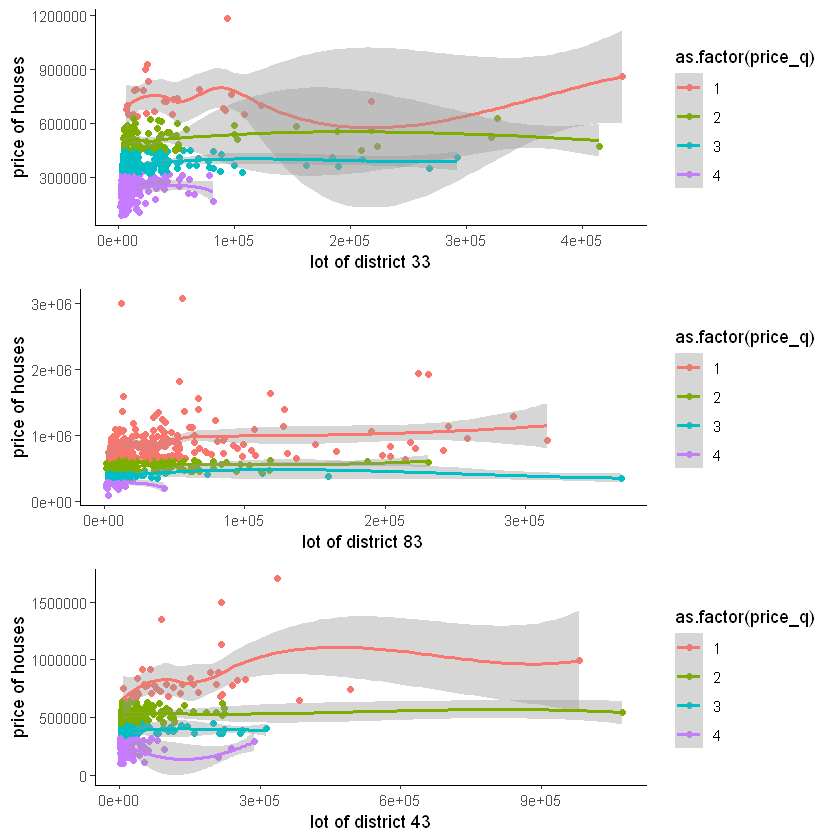

In [25]:
grid.arrange(district_6,district_7,district_8)

`geom_smooth()` using method = 'loess' and formula 'y ~ x'
`geom_smooth()` using method = 'loess' and formula 'y ~ x'
`geom_smooth()` using method = 'loess' and formula 'y ~ x'


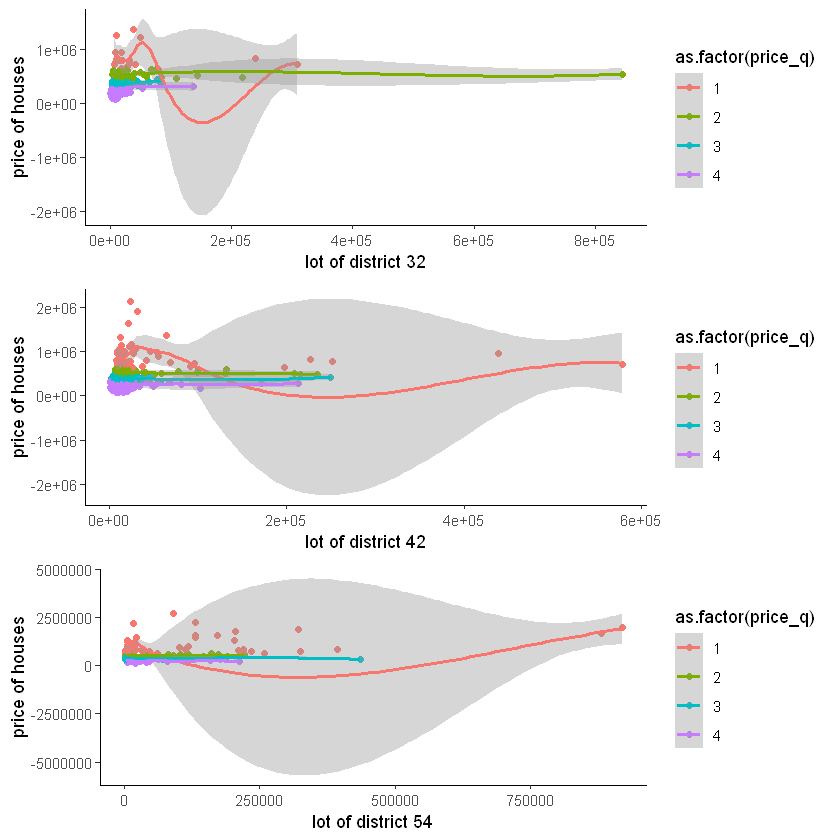

In [26]:
grid.arrange(district_9,district_10,district_11)

In [27]:
#price_per_space (new feature engineering)

summary(ifelse(kc_house$sqft_living==kc_house$sqft_above+kc_house$sqft_basement,1,0))

kc_house$price_per_lot<-kc_house$price/kc_house$sqft_lot
kc_house$price_per_living<-kc_house$price/kc_house$sqft_living
kc_house$price_per_all<-kc_house$price/(kc_house$sqft_lot+kc_house$sqft_living)
summary(kc_house$price_per_lot)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
      1       1       1       1       1       1 

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
   0.1631   32.9838   58.4308   88.4235  106.6206 1346.1538 

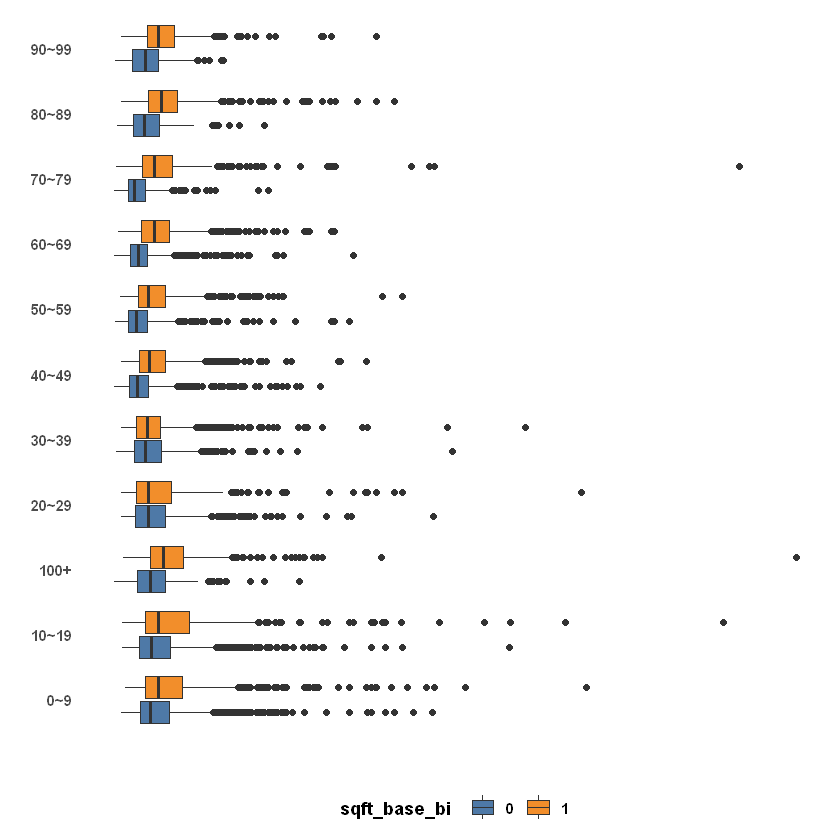

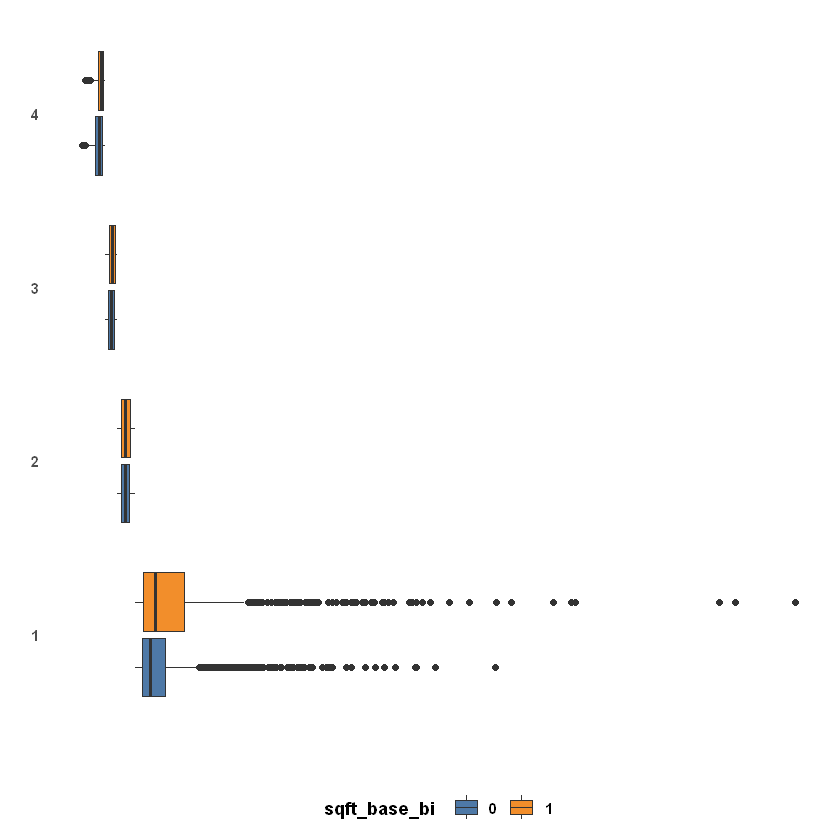

In [28]:

#base_binary_variable

kc_house$sqft_base_bi<-NA
kc_house$sqft_base_bi<-ifelse(kc_house$sqft_basement==0,"0","1")



base_1<-ggplot(kc_house, aes(age_sold_group, price)) +
    geom_boxplot(aes(fill = sqft_base_bi)) +
    coord_flip() +                                
    scale_fill_tableau() +
    labs(x = "", y = "") +
    theme_minimal() +
    theme(text = element_text(face = "bold"),
          legend.position = "bottom",
          panel.grid.major = element_blank(),
          panel.grid.minor = element_blank(),
          plot.title = element_text(hjust = 0.5),
          axis.text.x = element_blank())   

base_2<-ggplot(kc_house, aes(price_q, price)) +
    geom_boxplot(aes(fill = sqft_base_bi)) +
    coord_flip() +                                
    scale_fill_tableau() +
    labs(x = "", y = "") +
    theme_minimal() +
    theme(text = element_text(face = "bold"),
          legend.position = "bottom",
          panel.grid.major = element_blank(),
          panel.grid.minor = element_blank(),
          plot.title = element_text(hjust = 0.5),
          axis.text.x = element_blank())   

base_1
base_2

In [29]:
#rooms

kc_house$bath_per_bed<-ifelse(kc_house$bedrooms==0,0,kc_house$bathrooms/kc_house$bedrooms)
kc_house$rooms<-kc_house$bathrooms+kc_house$bedrooms
kc_house$living_per_lot<-kc_house$sqft_living/kc_house$sqft_lot

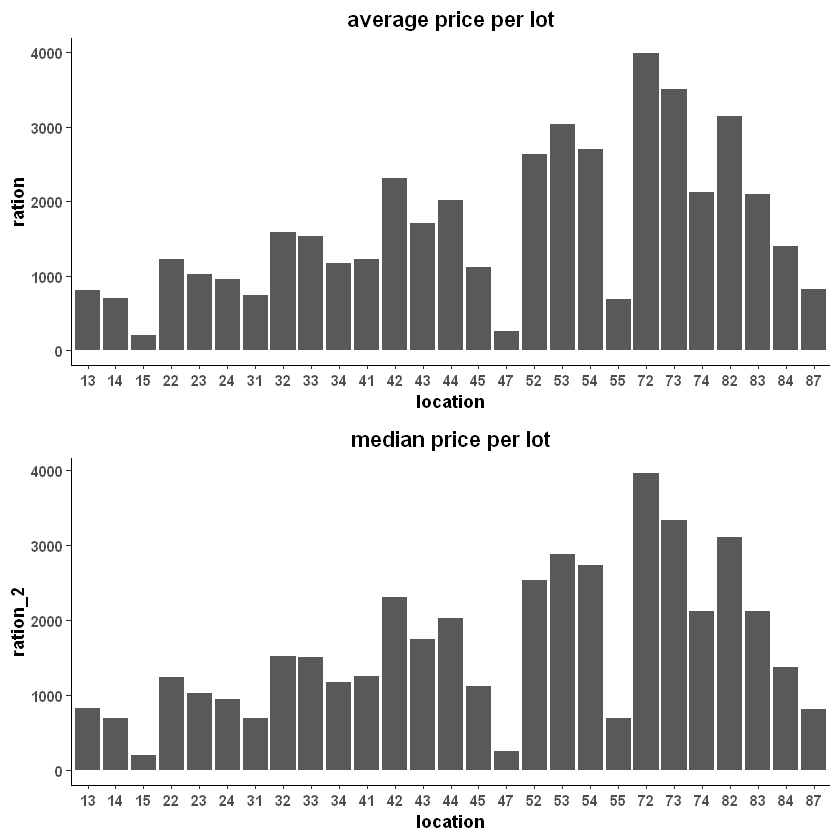

In [30]:



#summary for mean and median price per lot

summary_1<-kc_house%>%group_by(location,grade)%>%summarize(avg_living=mean(sqft_living),avg_price=mean(price))
summary_1$ration<-summary_1$avg_price/summary_1$avg_living

summary_2<-kc_house%>%group_by(location,grade)%>%summarize(m_living=median(sqft_living),m_price=median(price))
summary_2$ration_2<-summary_2$m_price/summary_2$m_living


kc_house$f_key<-paste(kc_house$grade,kc_house$location,sep="")
summary_1$f_key<-paste(summary_1$grade,summary_1$location,sep="")

kc_house<-left_join(kc_house,summary_1[,c(3:6)],by="f_key")

summary_2$f_key<-paste(summary_2$grade,summary_2$location,sep="")

kc_house<-left_join(kc_house,summary_2[,c(3:6)],by="f_key")




average_price<-ggplot(data=summary_1,aes(x=location, y=ration))+
    geom_bar(stat="identity")+
    ggtitle("average price per lot")+
    theme_classic()+
    theme(text=element_text(face="bold"),
          plot.title=element_text(hjust=0.5))

median_price<-ggplot(data=summary_2,aes(x=location, y=ration_2))+
    geom_bar(stat="identity")+
    ggtitle("median price per lot")+
    theme_classic()+
    theme(text=element_text(face="bold"),
          plot.title=element_text(hjust=0.5))


price_per_lot<- grid.arrange(average_price,median_price)

In [31]:

# zerovariacne check

nearZeroVar(kc_house,saveMetrics=TRUE)

,freqRatio,percentUnique,zeroVar,nzv
id,1.000000,99.41390585,FALSE,FALSE
date,1.010000,2.26417422,FALSE,FALSE
price,1.065041,20.84644333,FALSE,FALSE
bedrooms,1.445705,0.08020236,FALSE,FALSE
bathrooms,1.375514,0.18508236,FALSE,FALSE
sqft_living,1.028302,5.71904498,FALSE,FALSE
sqft_lot,1.241860,49.82417176,FALSE,FALSE
floors,1.319908,0.03701647,FALSE,FALSE
waterfront,125.632812,0.01233882,FALSE,TRUE
view,20.683168,0.03084706,FALSE,TRUE


In [32]:
num_var_2<-c("price","bedrooms","bathrooms","sqft_living",
             "sqft_lot","floors","view","sqft_above","sqft_basement",
             "lat","long","sqft_living15","sqft_lot15","age_sold",
             "age_sold_reno","dist","price_per_lot","price_per_living", 
             "price_per_all","bath_per_bed","rooms","living_per_lot",
             "avg_living","avg_price","ration","m_living","m_price",
             "ration_2")



distribution_2 <- as.data.frame(t(sapply(kc_house[,num_var_2], quantile)))
distribution_2$Mean <- sapply(kc_house[,num_var_2], mean)
distribution_2$SD <- sapply(kc_house[,num_var_2], sd)
distribution_2$skenewss <- sapply(kc_house[,num_var_2], skewness)
distribution_2$kurtosis <- sapply(kc_house[,num_var_2], kurtosis)
distribution_2<-round(distribution_2, 2)


distribution_2[which(distribution_2$skenewss>0),]

,0%,25%,50%,75%,100%,Mean,SD,skenewss,kurtosis
price,75000.00,322500.00,450000.00,640000.00,7700000.00,539118.63,371022.18,4.28,38.99
bedrooms,0.00,3.00,3.00,4.00,33.00,3.37,0.94,2.41,62.79
bathrooms,0.00,1.50,2.25,2.50,8.00,2.11,0.77,0.56,1.43
sqft_living,290.00,1420.00,1910.00,2538.00,12050.00,2075.63,919.65,1.46,4.70
sqft_lot,520.00,5100.00,7650.00,10769.00,1164794.00,15306.38,40714.07,11.31,197.67
floors,1.00,1.00,1.50,2.00,3.50,1.49,0.54,0.63,-0.46
view,0.00,0.00,0.00,0.00,4.00,0.24,0.77,3.39,10.80
sqft_above,290.00,1190.00,1550.00,2200.00,8860.00,1784.76,829.36,1.46,3.40
sqft_basement,0.00,0.00,0.00,560.00,4820.00,290.87,441.40,1.59,2.85
long,-122.52,-122.33,-122.23,-122.13,-121.31,-122.21,0.14,0.88,1.07


'data.frame':	16209 obs. of  50 variables:
 $ id              : num  3.33e+09 2.62e+09 7.22e+08 3.63e+09 2.62e+09 ...
 $ date            : chr  "20150504" "20140521" "20140905" "20140730" ...
 $ price           : num  190000 542500 998000 790000 1998000 ...
 $ bedrooms        : int  2 5 4 2 2 4 4 3 3 3 ...
 $ bathrooms       : num  1 3.25 3.25 3 2.5 3.25 5.5 2 2.5 2.5 ...
 $ sqft_living     : int  710 3010 3770 2560 3900 3920 6530 3650 2350 2530 ...
 $ sqft_lot        : int  1164794 1074218 982998 982278 920423 881654 871200 843309 715690 623779 ...
 $ floors          : num  1 1.5 2 1 2 3 2 2 1.5 1 ...
 $ waterfront      : Factor w/ 2 levels "0","1": 1 1 1 1 1 1 1 1 1 1 ...
 $ view            : int  0 0 0 0 0 3 2 0 0 0 ...
 $ condition       : Factor w/ 5 levels "4","3","5","1",..: 5 3 2 2 2 2 2 1 1 1 ...
 $ grade           : Factor w/ 12 levels "7","10","9","11",..: 8 6 2 6 7 4 4 1 3 6 ...
 $ sqft_above      : int  710 2010 3770 2560 3900 3920 6530 3650 2350 2530 ...
 $ sqft_basement 

[1] "id"            "date"          "price"         "bedrooms"     
 [5] "bathrooms"     "sqft_living"   "sqft_lot"      "floors"       
 [9] "waterfront"    "view"          "condition"     "grade"        
[13] "sqft_above"    "sqft_basement" "yr_built"      "yr_renovated" 
[17] "zipcode"       "lat"           "long"          "sqft_living15"
[21] "sqft_lot15"


Call:
 randomForest(formula = price ~ bedrooms + bathrooms + sqft_living +      sqft_lot + floors + waterfront + view + condition + grade +      sqft_above + sqft_basement + yr_built + lat + long + sqft_living15 +      sqft_lot15, data = kc_house_base, importance = TRUE) 
               Type of random forest: regression
                     Number of trees: 500
No. of variables tried at each split: 5

          Mean of squared residuals: 17612547765
                    % Var explained: 87.2

,%IncMSE,IncNodePurity
bedrooms,9.062169,1.582701e+13
bathrooms,15.022037,1.176609e+14
sqft_living,37.475357,5.021867e+14
sqft_lot,29.538184,4.122088e+13
floors,13.540394,9.759005e+12
waterfront,26.123128,5.109150e+13
view,20.570968,7.204059e+13
condition,16.722460,1.094316e+13
grade,32.788197,4.154004e+14
sqft_above,20.058635,1.812722e+14


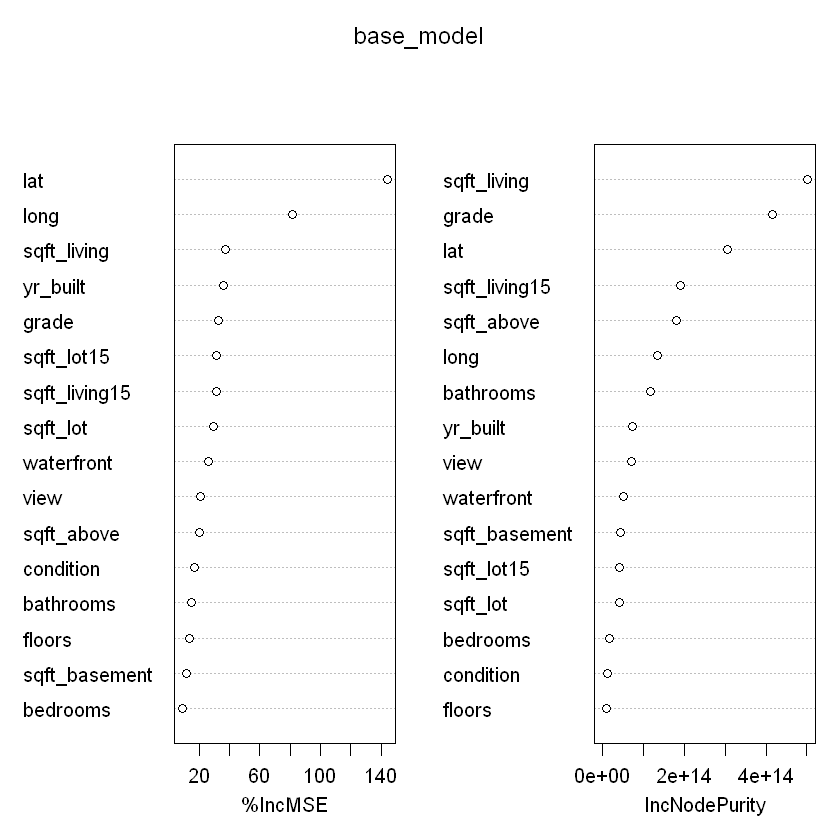

In [33]:
#base_model

str(kc_house)

colnames(kc_house_base)

kc_house_base$waterfront<-as.factor(kc_house_base$waterfront)
kc_house_base$condtion<-as.factor(kc_house_base$condition)
kc_house_base$grade<-as.factor(kc_house_base$grade)
kc_house_base$zipcode<-as.factor(kc_house_base$zipcode)

base_model<-randomForest(price~bedrooms+bathrooms+sqft_living+sqft_lot+
                    floors+waterfront+view+condition+grade+
                    sqft_above+sqft_basement+yr_built+
                    lat+long+sqft_living15+sqft_lot15, 
                    data=kc_house_base, importance=TRUE)

base_model
importance(base_model)
varImpPlot(base_model)

mtry = 2  OOB error = 20120868683 
Searching left ...
mtry = 1 	OOB error = 27402763484 
-0.3619076 0.05 
Searching right ...
mtry = 4 	OOB error = 17590398337 
0.1257635 0.05 
mtry = 8 	OOB error = 17379556927 
0.01198616 0.05 


,mtry,OOBError
1,1,27402763484
2,2,20120868683
4,4,17590398337
8,8,17379556927


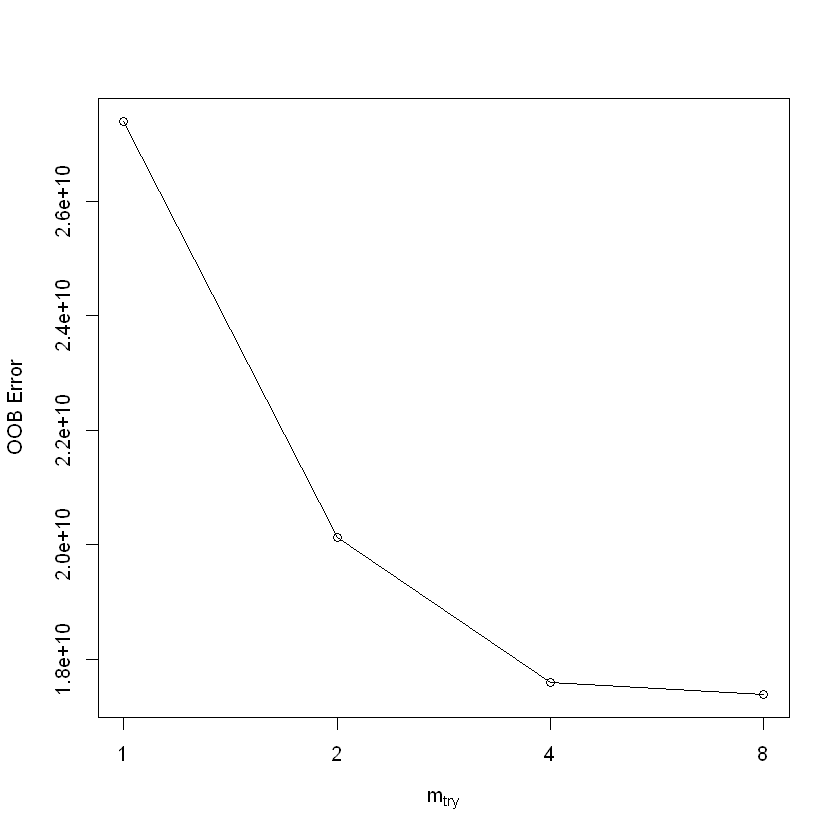

In [36]:

tuneRF(kc_house[,c("sqft_living","sqft_lot","floors","waterfront",
                    "view","grade","lat","long","sqft_living15","location",
                    "dist","sqft_base_bi","bath_per_bed","living_per_lot",
                    "avg_living","avg_price","ration","m_living","m_price","ration_2",
                    "age_sold","age_sold_reno","yr_renovated_bi")],kc_house$price,mtryStart=2)


,%IncMSE,IncNodePurity
sqft_living,91.126988,3.930323e+14
sqft_lot,30.227358,3.305689e+13
floors,20.585518,5.037216e+12
waterfront,50.235623,5.631045e+13
view,25.152088,2.993630e+13
grade,4.742884,2.380133e+13
lat,49.960761,4.871104e+13
long,41.712736,6.619737e+13
sqft_living15,61.132474,6.557174e+13
location,13.600068,5.787466e+12


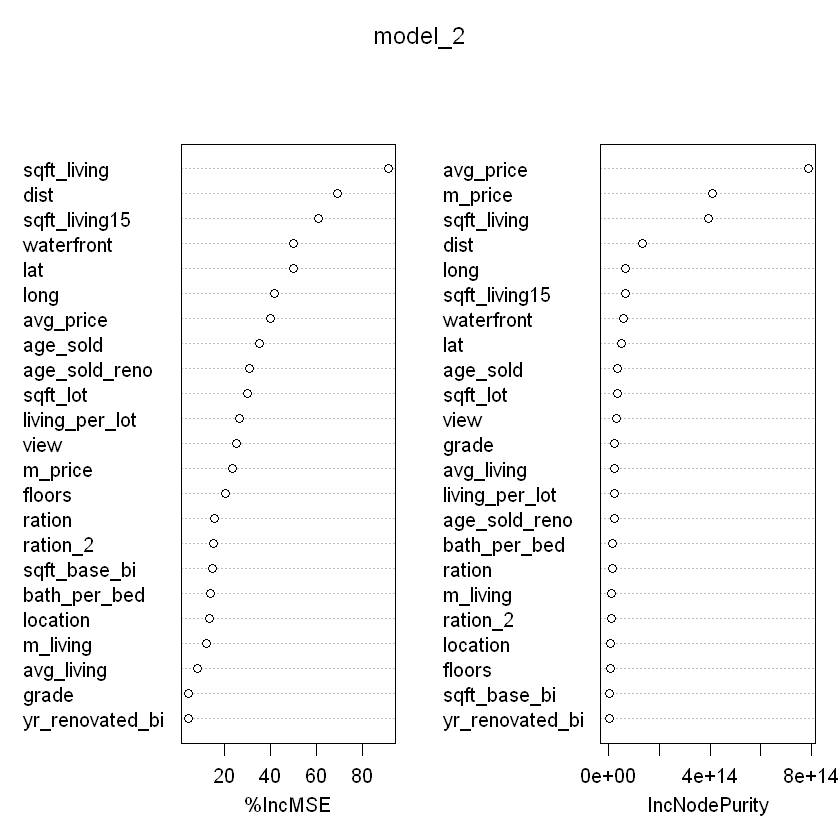

In [34]:
model_2<-randomForest(price~sqft_living+sqft_lot+floors+waterfront+
                        view+grade+lat+long+sqft_living15+location+
                        dist+sqft_base_bi+bath_per_bed+living_per_lot+
                        avg_living+avg_price+ration+m_living+m_price+ration_2+
                        age_sold+age_sold_reno+yr_renovated_bi,
                    data=kc_house,ntree=600,mtry=16,importance=TRUE)

importance(model_2)
varImpPlot(model_2)

In [35]:
# before parameter tuing  : 88.37
model_2


Call:
 randomForest(formula = price ~ sqft_living + sqft_lot + floors +      waterfront + view + grade + lat + long + sqft_living15 +      location + dist + sqft_base_bi + bath_per_bed + living_per_lot +      avg_living + avg_price + ration + m_living + m_price + ration_2 +      age_sold + age_sold_reno + yr_renovated_bi, data = kc_house,      ntree = 600, mtry = 16, importance = TRUE) 
               Type of random forest: regression
                     Number of trees: 600
No. of variables tried at each split: 16

          Mean of squared residuals: 15485193978
                    % Var explained: 88.75